Attempting to convert [this notebook](https://colab.research.google.com/drive/12xmTDBYssfFVMUs0XhGXWP42SN6mijtt?usp=sharing#scrollTo=wngfK4auxtvV) to fastai.

References:

- [Etienne's fastai VAE implementation](https://github.com/EtienneT/vae/blob/master/vae.ipynb) ([via](https://forums.fast.ai/t/fastai-v2-variational-autoencoder/85684/3?u=seem))

In [ ]:
from fastai.data.all import *
from fastai.vision.all import *
from fastprogress import progress_bar

import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW),ImageBlock(cls=PILImageBW)),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter('training', 'testing'))

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
dls = dblock.dataloaders(path, bs=128)

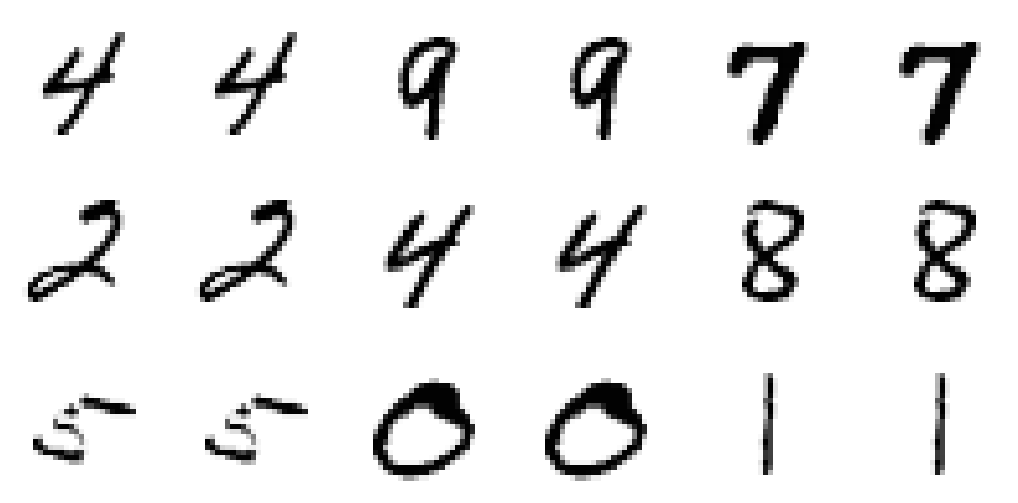

In [ ]:
dls.show_batch()

In [ ]:
class BasicConvNet(Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, hidden_channels=32, n_layers=4):
        super().__init__()
        padding = kernel_size // 2 # So we keep output size the same
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size,  padding=padding),
            nn.ReLU(),
            *[nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding),
            nn.ReLU()]*n_layers, # n_layers duplicates of this
            nn.Conv2d(hidden_channels, out_channels, kernel_size, padding=padding))
    def forward(self, x): return self.net(x)

In [ ]:
ims,_ = dls.one_batch()
im = ims[0]

In [ ]:
model = BasicConvNet(1, 1).cuda()
test_eq(im.shape, model(im).shape)

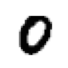

In [ ]:
im.show();

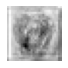

In [ ]:
model(im).show();

In [ ]:
model = BasicConvNet(1, 1, hidden_channels=64).cuda()
learn = Learner(dls, model, loss_func=MSELossFlat(), lr=5e-4)

In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,time
0,0.000714,0.000477,00:38


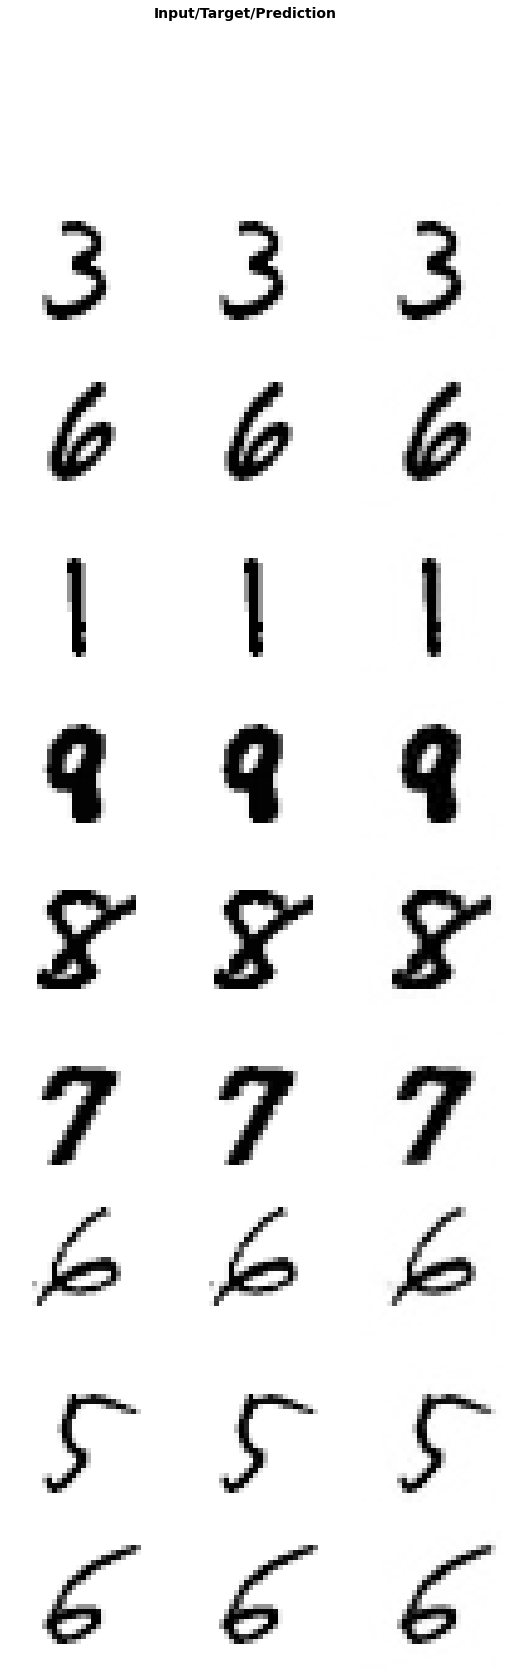

In [ ]:
learn.show_results()

## Corrupt

In [ ]:
from torch import Tensor

In [ ]:
class Corrupt(Transform):
    def __init__(self, amount):
        if not isinstance(amount, Tensor): amount = torch.tensor(amount, device=device)
        self.amount = amount
    def encodes(self, x: TensorImage):
        noise = torch.rand_like(x, device=x.device)
        single = x.ndim < 4
        if single: x = x.view(1, *x.shape)
        amount = self.amount.view(-1, *(1,)*(x.dim()-1))
        return ((1-amount)*x + amount*noise).squeeze()

In [ ]:
ims,_ = dls.one_batch()
im = ims[0]

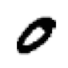

In [ ]:
im.show();

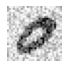

In [ ]:
Corrupt(0.5)(im).show();

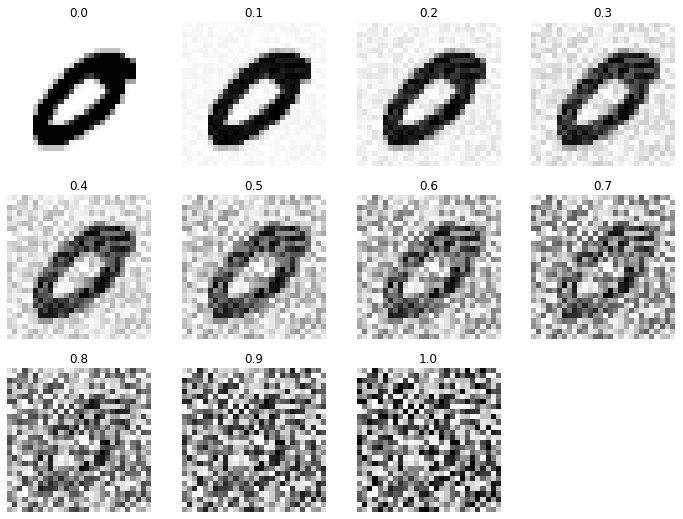

In [ ]:
amount = torch.arange(0, 1.1, 0.1, device=im.device)
noised_x = Corrupt(amount)(im)
show_batch(c, None, L([(i,Category(round(a.item(), 1))) for i,a in zip(noised_x,amount)]), max_n=len(amount));

Starting epoch 0
Average of the last 100 loss values: 0.020176224503666164
Starting epoch 1
Average of the last 100 loss values: 0.018202130300924182
Starting epoch 2
Average of the last 100 loss values: 0.016760665457695723
Starting epoch 3
Average of the last 100 loss values: 0.015372531125321984
Starting epoch 4
Average of the last 100 loss values: 0.014612878235056996


[<matplotlib.lines.Line2D>]

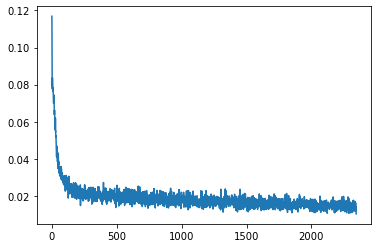

In [ ]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(mnist_dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 5

# Create the network (try changing hidden_channels and n_layers)
net = BasicConvNet(1, 1, hidden_channels=64)
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=5e-4) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
  print(f'Starting epoch {epoch}')
  for x, y in train_dataloader:

    # Get some data and prepare the corrupted version
    x = x.to(device) # Data on the GPU
    noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
    noisy_x = corrupt(x, noise_amount) # Create our noisy x

    # Get the model prediction
    pred = net(noisy_x)

    # Calculate the loss
    loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

    # Backprop and update the params:
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Store the loss for later
    losses.append(loss.item())

  # Print our the average of the last 100 loss values to get an idea of progress:
  print('Average of the last 100 loss values:', sum(losses[-100:])/100)

# View the loss curve
plt.plot(losses)

<matplotlib.image.AxesImage>

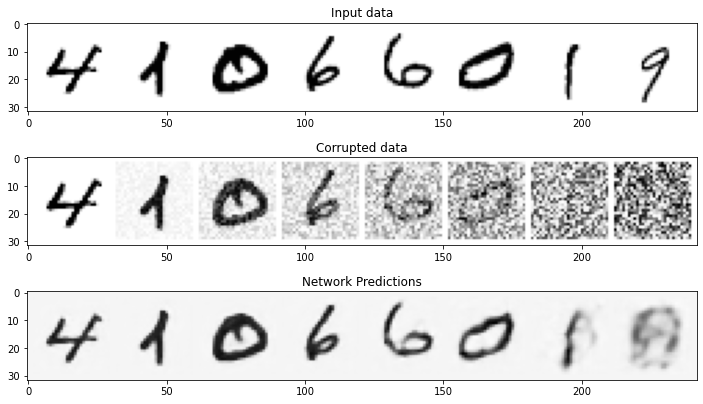

In [ ]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0], cmap='Greys')

## Debug

### PyTorch

In [ ]:
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

mnist_dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

class BasicConvNet(nn.Module):
    def __init__(self, in_channels, out_channels,
                 kernel_size=5, hidden_channels = 32, n_layers=4 ):
        super().__init__()
        padding = kernel_size // 2 # So we keep output size the same
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size,  padding=padding),
            nn.ReLU(),
            *[nn.Conv2d(hidden_channels, hidden_channels, kernel_size, padding=padding),
            nn.ReLU()]*n_layers, # n_layers duplicates of this
            nn.Conv2d(hidden_channels, out_channels, kernel_size, padding=padding),
        )

    def forward(self, x):
        return self.net(x)
    
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(mnist_dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 5

# Create the network (try changing hidden_channels and n_layers)
net = BasicConvNet(1, 1, hidden_channels=64)
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=5e-4) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
  print(f'Starting epoch {epoch}')
  for x, y in train_dataloader:

    # Get some data and prepare the corrupted version
    x = x.to(device) # Data on the GPU

    # Get the model prediction
    pred = net(x)

    # Calculate the loss
    loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

    # Backprop and update the params:
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Store the loss for later
    losses.append(loss.item())

  # Print our the average of the last 100 loss values to get an idea of progress:
  print('Average of the last 100 loss values:', sum(losses[-100:])/100)

# View the loss curve
plt.plot(losses)

Using device: cuda
Starting epoch 0
Average of the last 100 loss values: 0.0006131474135327153
Starting epoch 1


KeyboardInterrupt: 

### fastai w/o Learner API

In [ ]:
n_epoch = 1

model = BasicConvNet(1, 1, hidden_channels=64).cuda()
loss_func = MSELossFlat()
opt = torch.optim.Adam(model.parameters(), lr=5e-4) 

pbar = progress_bar(dls.train)
test = model(im)
for epoch in progress_bar(list(range(n_epoch))):
    for x,y in pbar:
        pred = model(x)
        loss = loss_func(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        pbar.comment = f'{loss:.4f}'
        assert not torch.all(model(im) == test)
    print(loss)

KeyboardInterrupt: 